### Détectection des faux billets avec Python

## 1. Preliminary

     *** Contexte ***

Identification des contrefaçons des billets en euros

Les billets d'euro ont des valeurs nominales de 5, 10, 20, 50, 100, 200 et 500 euros. 

In [20]:
!python -V


Python 3.9.13


## 1.1 Install

In [21]:
#

# 1.2 Importation

## 1.2.1 Importation des librairies

In [22]:
#builtin
import os

In [23]:

#data
import pandas as pd
import numpy as np

In [24]:

#visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
%matplotlib inline

In [25]:
#machine learning
from sklearn.linear_model import LinearRegression

## 2.1 chargement des fichiers

In [26]:
input_folder = r"C:\Users\Nada\Desktop\OpenClassRooms\Projet 10\Data\0 Source"
# Read CSV train data file into DataFrame
train_df= pd.read_csv(os.path.join(input_folder, "billets.csv"), dtype=float, sep=';')
# Read CSV test data file into DataFrame
test_df = pd.read_csv(os.path.join(input_folder, "billets_production.csv"), sep=',')


## 2. Prétraitement des données

## 2.2 Exploration

In [27]:
#Affichage des 5 premieres lignes
train_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [28]:
print('The number of samples into the train data is {}.'.format(train_df.shape[0]))

The number of samples into the train data is 1500.


In [29]:
# preview test data
test_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [30]:
print('The number of samples into the test data is {}.'.format(test_df.shape[0]))

The number of samples into the test data is 5.


Note: there is no target variable into test data (i.e. "is_genuine" column is missing), so the goal is to predict this target using different machine learning algorithms such as logistic regression.

In [ ]:
#Affichage des 5 dernieres lignes
train_df.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,0.0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0.0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0.0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0.0,172.06,104.28,104.06,5.17,3.46,112.25
1499,0.0,171.47,104.15,103.82,4.63,3.37,112.07


In [ ]:
#Affichage de 5 lignes arbitrairement
train_df.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
533,1.0,172.33,103.73,103.80,3.77,2.86,113.58
1309,0.0,172.00,104.45,104.19,5.50,2.99,111.99
1200,0.0,171.99,104.04,104.25,4.77,3.43,111.83
1118,0.0,171.38,104.52,104.22,4.58,3.41,111.84
762,1.0,172.02,104.01,103.57,4.50,2.77,112.72


In [ ]:
#Dimensions du DataFrame
train_df.shape

(1500, 7)

In [ ]:
#Information sur les colonnes
train_df.dtypes

is_genuine      float64
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [ ]:
#Statistiques descriptives
train_df.describe().round(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,0.67,171.96,104.03,103.92,4.49,3.15,112.68
std,0.47,0.31,0.30,0.33,0.66,0.23,0.87
min,0.00,171.04,103.14,102.82,2.98,2.27,109.49
25%,0.00,171.75,103.82,103.71,4.01,2.99,112.03
50%,1.00,171.96,104.04,103.92,4.31,3.14,112.96
75%,1.00,172.17,104.23,104.15,4.87,3.31,113.34
max,1.00,173.01,104.88,104.95,6.90,3.91,114.44


In [ ]:
#Nombre des doublons dans le DataFrame
df_orig.duplicated().sum()

0

In [ ]:
#Nombre des doublons sans le target
df_orig.drop(columns="is_genuine").duplicated().sum()

0

In [ ]:
#Information sur les valeurs unique dans chaque colonne
df_orig.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [ ]:
#Nombre des valeurs dans la target
df_orig['is_genuine'].value_counts()

is_genuine
1.0    1000
0.0     500
Name: count, dtype: int64

In [ ]:
#creation de la colonne target
df_orig.rename(columns={'is_genuine':'target'}, inplace=True)

On a 37 valeurs manquantes dans la colonne margin_low

## 2.3 Nettoyage des données

In [ ]:
#Nombre des valeurs manquantes dans chaque colonne
train_df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [33]:
# Pourçentage des valeurs manquantes 
print('Percent of missing "margin_low" records is %.2f%%' %((train_df['margin_low'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "margin_low" records is 2.47%


~2,5% de donnée sur margin_low est manquantes. -> voir la distribution de cette variable

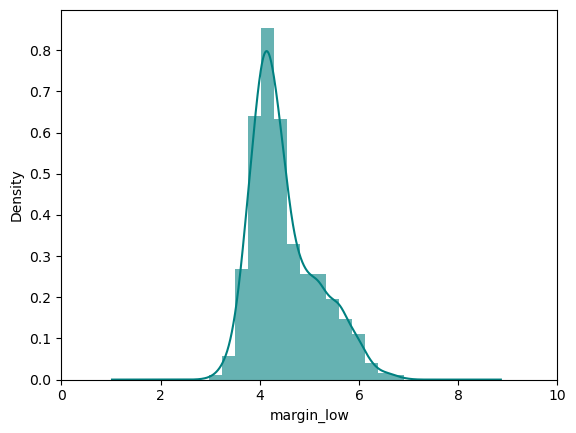

In [35]:
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

la mediane de margin_low est indique entre 4 et 5 mm. On va essayer la regression pour l'imputation des valeurs manquantes.

### 2.3.1 Imputation des valeurs manquantes

In [ ]:
df=df_orig.copy()

In [ ]:
## elimination de la colonne target
df.drop(['target'], axis=1, inplace=True)

On a un DataFrame qui contient X=6 (features)

## Regression lineaire

les valeurs manquantes sont de type numerique

#Choix de la methode regression lineaire pour l'imputation des valeurs manquantes

In [ ]:
# Séparer les données en deux ensembles : avec et sans valeurs manquantes

test_data = df[df['margin_low'].isna()] #DataFrame qui contient que les valeurs manquantes

train_data = df[~df['margin_low'].isna()] #dataframe sans valeurs manquantes

In [ ]:
test_data.shape

(37, 6)

In [ ]:
train_data.shape

(1463, 6)

In [ ]:
# Diviser les données en variables explicatives (X) et la variable cible (y)
#les variables explicative (X)
X_train = train_data.drop(columns=['margin_low'])
X_train

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...
1495,171.75,104.38,104.17,3.09,111.28
1496,172.19,104.63,104.44,3.37,110.97
1497,171.80,104.01,104.12,3.36,111.95
1498,172.06,104.28,104.06,3.46,112.25


In [ ]:
# Diviser les données en variables explicatives (X) et la variable cible (y)
#la variable cible (y) (target)
y_train= train_data['margin_low']
y_train.shape

(1463,)

In [ ]:
## Model
# Créer et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
#creation de la variable X_test
X_test = test_data.drop(columns=['margin_low'])

In [ ]:
# Prédire les valeurs manquantes
y_predicted = model.predict(X_test)

In [ ]:
y_predicted.shape

(37,)

In [ ]:
# Remplacer les valeurs manquantes par les valeurs prédites
df.loc[df['margin_low'].isna(), 'margin_low'] = y_predicted

In [ ]:
y_predicted

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [ ]:
y_predicted.shape

(37,)

In [ ]:
df.isnull().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

## 2.3.2 Detection des outliers

## 2.3.1.1 Data mining

## 2.4 Preparation des données